In [ ]:
Chunyang Zhu

In [21]:
#download the CIFAR10 dataset for image classification.
import torch, torchvision
import numpy as np
import random

transform = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

testdata = []
for data in testset:
    tmp = []
    tmp.append(data[0].numpy().ravel())
    tmp.append(data[1])
    testdata.append(tmp)
    
test_X = [item[0].tolist() for item in testdata]

print(len(testdata))
#preprocess trainset.
dataset = []
#flat dataset
for data in trainset:
  tmp = []
  tmp.append(data[0].numpy().ravel())
  tmp.append(data[1])
  dataset.append(tmp)


random.shuffle(dataset)
#separate features and label
dataset_X = [item[0].tolist() for item in dataset]
dataset_Y = [item[1] for item in dataset]

#combined training sample:
training_set = dataset[5000:]

#split dataset into training set and validation set and format the dataset

valiset_X = np.asarray(dataset_X[:5000])
valiset_Y = dataset_Y[:5000]


trainset_X = np.asarray(dataset_X[5000:]) #shape (num of training data, num of features)
trainset_Y = dataset_Y[5000:]



Files already downloaded and verified
Files already downloaded and verified
10000


In [ ]:
import matplotlib.pyplot as plt
class NeuralNetwork:
  
  def __init__(self, layer_dimensions):
    #initialize weights and bias
    self.parameters = {}
    self.cache = {}
    self.num_layers = len(layer_dimensions) - 1
    for l in range (1, self.num_layers + 1):
      eps = np.sqrt(2.0 / (layer_dimensions[l] + layer_dimensions[l - 1]))
      self.parameters["W" + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l - 1]) * eps #shape (features, neurons)
      self.parameters["b" + str(l)] = np.zeros((layer_dimensions[l], 1)) + 0.01 #shape (1,n)
  
  def affineForward(self, A, W, b, layer):
    forward = np.dot(W, A) + b
    self.cache["Z" + str(layer)] = forward
    return forward
    
  def activationForward(self, A, layer):
    # use relu function as activation function
    A = np.maximum(0, A)
    self.cache["A" + str(layer)] = A
    return A
  
  def _softmax(self, AL):
    num_data = AL.shape[1]
    result = np.zeros(AL.shape)
    # matrix of 1s
    for n in range(num_data):
      curr = AL[:,n]
      e_curr = np.exp(curr - np.max(curr))
      result[:,n] = e_curr/np.sum(e_curr)
    return result
  
  def costFunction(self, AL, y):
    AL_softmax = self._softmax(AL)
    # calculate cross entropy loss
    n = len(y)
    log_likelyhood = -np.log(AL_softmax[y, range(n)]++1e-9)
    loss = np.sum(log_likelyhood) / n
    return loss
  
  
  def affineBackward(self, dL_dZ, layer, rate):
    A = self.cache["A" + str(layer - 1)]
    dL_dW = np.dot(dL_dZ ,A.transpose())
    W = self.parameters["W" + str(layer)]
    self.parameters["W" + str(layer)] =  self.parameters["W" + str(layer)] - rate * dL_dW
    self.parameters["b" + str(layer)] =  self.parameters["b" + str(layer)] - rate * np.dot(dL_dZ, np.ones((dL_dZ.shape[1],1)))
    return np.dot(W.transpose(), dL_dZ)
     
  
  
  def activationBackward(self, dL_dA, layer):
    Z = self.cache["Z" + str(layer - 1)]
    Z[Z <= 0] = 0
    Z[Z > 1] = 1
    # multiplication
    return dL_dA*Z
    
    
    
    
  def backPropagation(self, y):
    AL = self.cache["Z" + str(self.num_layers)]
    grad = self._softmax(AL)
    n = len(y)
    grad[y, range(n)] -= 1
    grad = grad / n
    return grad
  
  def forward(self, X_train):
    self.cache["A0"] = X_train
    for layer in range(1, self.num_layers):
      Z = self.affineForward(self.cache["A"+ str(layer - 1)], self.parameters["W" + str(layer)], self.parameters["b" + str(layer)], layer)
      A = self.activationForward(Z, layer)
    Z = self.affineForward(self.cache["A" + str(self.num_layers - 1)], self.parameters["W" + str(self.num_layers)], self.parameters["b" + str(self.num_layers)], self.num_layers)
    return Z
  
  def predict(self, X_test):
    Z = self.forward(X_test)
    Z = self._softmax(Z)
    Y_Pred = np.argmax(Z, axis=0)
    return Y_Pred

  def validate(self, valiset_X, valiset_Y):
    Y_pred = self.predict(valiset_X)
    correct = 0
    for i in range(0, len(Y_pred)):
      if (Y_pred[i] == valiset_Y[i]):
        correct += 1
    return correct / len(valiset_Y)
  
  def train(self, trainset, X_val, Y_val, iters, alpha, batch_size):
    
    for iter in range(iters):
      print("Iteration: " + str(iter))
      random.shuffle(trainset)
      X_train = [item[0].tolist() for item in trainset]
      Y_train = [item[1] for item in trainset]
      l = 0
      for i in range(0, len(X_train)-1, batch_size):
        X_train_mini = np.transpose(X_train[i : i + batch_size])
        Y_train_mini = np.transpose(Y_train[i : i + batch_size])
        Z = self.forward(X_train_mini)
        loss = self.costFunction(Z,Y_train_mini)
        dL_dZ = self.backPropagation(Y_train_mini)
        for layer in range(self.num_layers, 0, -1):
          dL_dA = self.affineBackward(dL_dZ,layer, alpha)
          if layer > 1:
            dL_dZ = self.activationBackward(dL_dA, layer)
        l = loss
      train_accuracy = self.validate(trainset_X.transpose(), trainset_Y)
      validate_accuracy = self.validate(valiset_X.transpose(), valiset_Y)
      
        
      print("training loss is ", l)
      print("training accuracy is ", train_accuracy)
      print("validation accuracy is ", validate_accuracy)
      print(" ")
        
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
if __name__ == "__main__":
    layer_dimensions = [3072, 600, 500, 10]
    nn = NeuralNetwork(layer_dimensions)
    #nn.train(training_set, [], [], 15, 0.01, 50)
    with open(b"model.obj","rb") as f:
        model = pickle.load(f)
        label = ["plane", "car"," bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        Y_predict = model.predict(np.asarray(test_X).transpose())
        index = 900
        imshow(testset[index][0])
        print("The label is ", label[Y_predict[index]])

The label is  deer


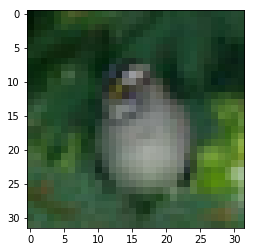

The label is  horse


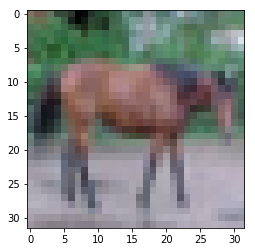

The label is  truck


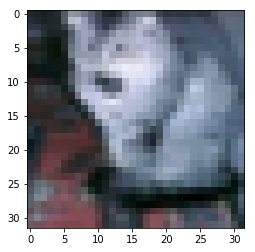

The label is  frog


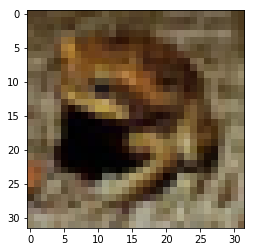

The label is  car


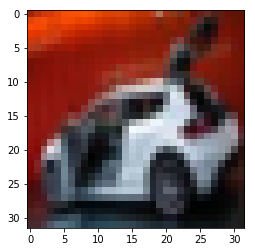

The label is  plane


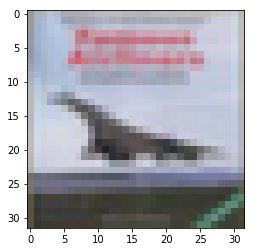

The label is  plane


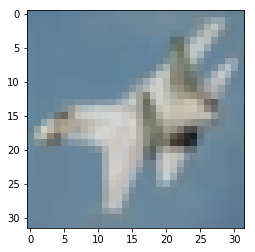

In [24]:
Iteration: 0
training loss is  1.7764639465987546
training accuracy is  0.40275555555555553
validation accuracy is  0.3888
 
Iteration: 1
training loss is  1.747398341337623
training accuracy is  0.4446
validation accuracy is  0.4332
 
Iteration: 2
training loss is  1.6867776195266115
training accuracy is  0.4696
validation accuracy is  0.4464
 
Iteration: 3
training loss is  1.3833475200976517
training accuracy is  0.4975777777777778
validation accuracy is  0.467
 
Iteration: 4
training loss is  1.3868560710314843
training accuracy is  0.5142222222222222
validation accuracy is  0.4802
 
Iteration: 5
training loss is  1.3291142033425338
training accuracy is  0.5268666666666667
validation accuracy is  0.4924
 
Iteration: 6
training loss is  1.281938767161841
training accuracy is  0.5373555555555556
validation accuracy is  0.4852
 
Iteration: 7
training loss is  1.500319052193226
training accuracy is  0.5626666666666666
validation accuracy is  0.5008
 
Iteration: 8
training loss is  1.1904887867307246
training accuracy is  0.5728888888888889
validation accuracy is  0.5064
 
Iteration: 9
training loss is  1.5766854566462172
training accuracy is  0.5815555555555556
validation accuracy is  0.5118
 
Iteration: 10
training loss is  1.360174404643718
training accuracy is  0.6003111111111111
validation accuracy is  0.5176
 
Iteration: 11
training loss is  1.279970640307238
training accuracy is  0.6043111111111111
validation accuracy is  0.5174
 
Iteration: 12
training loss is  1.1442031490033984
training accuracy is  0.629
validation accuracy is  0.529
 
Iteration: 13
training loss is  1.1652994774786445
training accuracy is  0.6316
validation accuracy is  0.5292
 
Iteration: 14
training loss is  0.9718383981359372
training accuracy is  0.6466444444444445
validation accuracy is  0.531

SyntaxError: invalid syntax (<ipython-input-24-658a9479dde0>, line 2)

In [0]:
# This part uses Google Colab and the link is:
# https://colab.research.google.com/drive/1NSgEyUrCFoxeN6BUZT7RZws6gJW1957p

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000]) # 10% for validation
small_testset, big_testset = torch.utils.data.random_split(testset, [5, 9995]) # 10 random images for image showing and prediction

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=1000, shuffle=False)
small_testloader = torch.utils.data.DataLoader(small_testset, batch_size=5, shuffle=False)

Files already downloaded and verified


In [0]:
# Default Model
class CNNModel(nn.Module):
  def __init__(self):
      super(CNNModel, self).__init__()
      # input is 2*32*32
      # padding=2
      self.conv1 = nn.Conv2d(3,96,6, padding = 4)
      self.norm1 = nn.BatchNorm2d(96)
      self.conv2 = nn.Conv2d(96,192,6, padding = 4)
      self.norm2 = nn.BatchNorm2d(192)
      self.fc1 = nn.Linear(192*10*10,2048)
      self.fc2 = nn.Linear(2048,10)
    
  def forward(self, x):
      x = F.max_pool2d(self.norm1(F.relu(self.conv1(x))),2)
      x = F.max_pool2d(self.norm2(F.relu(self.conv2(x))),2)
      x = x.view(-1, 192*10*10)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return F.log_softmax(x,dim=0)

In [5]:
model = CNNModel()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CNNModel(
  (conv1): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 192, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=19200, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
)


In [6]:
batch_size = 50
model.cuda()
model.train()
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               
        outputs = model(images)             
        loss = F.nll_loss(outputs, labels)  
        loss.backward()                     
        train_loss.append(loss.item())
        optimizer.step()                    
        predictions = outputs.data.max(1)[1]  
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1


Train Step: 0	Loss: 3.931	Accuracy: 6.000
Train Step: 1000	Loss: 2.571	Accuracy: 70.000
Train Step: 2000	Loss: 2.161	Accuracy: 90.000
Train Step: 3000	Loss: 2.135	Accuracy: 82.000
Train Step: 4000	Loss: 1.996	Accuracy: 96.000
Train Step: 5000	Loss: 1.936	Accuracy: 98.000
Train Step: 6000	Loss: 2.046	Accuracy: 90.000
Train Step: 7000	Loss: 1.911	Accuracy: 98.000
Train Step: 8000	Loss: 1.843	Accuracy: 98.000
Train Step: 9000	Loss: 1.981	Accuracy: 92.000
Train Step: 10000	Loss: 1.829	Accuracy: 98.000
Train Step: 11000	Loss: 1.806	Accuracy: 98.000
Train Step: 12000	Loss: 1.714	Accuracy: 100.000
Train Step: 13000	Loss: 1.799	Accuracy: 100.000


In [7]:
# Prediction on Validation Set
model.eval()
correct = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

Validation set accuracy: 79.00%


In [0]:
# Modified Version 1. Add one more convolution layer. Add drop out. Change the activation function
class ModelV1(nn.Module):
  def __init__(self):
      super(ModelV1, self).__init__()
      # input is 2*32*32
      # padding=2
      self.conv1 = nn.Conv2d(3,96,6, padding = 4)
      self.norm1 = nn.BatchNorm2d(96)
      self.conv2 = nn.Conv2d(96,192,6, padding = 4)
      self.norm2 = nn.BatchNorm2d(192)
      self.conv3 = nn.Conv2d(192,384,6, padding = 4)
      self.norm3 = nn.BatchNorm2d(384)
      self.fc1 = nn.Linear(384*6*6,2048)
      self.fc2 = nn.Linear(2048,10)
    
  def forward(self, x):
      x = F.max_pool2d(self.norm1(F.relu(self.conv1(x))),2)
      x = F.max_pool2d(self.norm2(torch.sigmoid(self.conv2(x))),2)
      x = F.max_pool2d(self.norm3(F.hardtanh(self.conv3(x))),2)
      x = x.view(-1, 384*6*6)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, training=self.training) # default p=0.5
      x = self.fc2(x)
      return F.log_softmax(x,dim=0)

In [10]:
model1 = ModelV1()
print(model1)

optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

ModelV1(
  (conv1): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 192, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(192, 384, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=13824, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
)


In [11]:
batch_size = 50
model1.cuda()
model1.train()
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model1(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

Train Step: 0	Loss: 3.980	Accuracy: 8.000
Train Step: 1000	Loss: 3.030	Accuracy: 52.000
Train Step: 2000	Loss: 2.718	Accuracy: 70.000
Train Step: 3000	Loss: 2.379	Accuracy: 80.000
Train Step: 4000	Loss: 2.281	Accuracy: 78.000
Train Step: 5000	Loss: 2.113	Accuracy: 86.000
Train Step: 6000	Loss: 2.182	Accuracy: 86.000
Train Step: 7000	Loss: 2.141	Accuracy: 84.000
Train Step: 8000	Loss: 2.210	Accuracy: 76.000
Train Step: 9000	Loss: 1.930	Accuracy: 90.000
Train Step: 10000	Loss: 1.839	Accuracy: 100.000
Train Step: 11000	Loss: 1.858	Accuracy: 100.000
Train Step: 12000	Loss: 1.844	Accuracy: 100.000
Train Step: 13000	Loss: 1.733	Accuracy: 100.000


In [13]:
model1.eval()
correct = 0
i = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model1(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

Validation set accuracy: 80.00%


In [26]:
# Modified Version 2. Use a different optimizer: ASGD
model2 = ModelV1()
print(model2)

optimizer2 = optim.ASGD(model2.parameters(), lr=0.01)

ModelV1(
  (conv1): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 192, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(192, 384, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=13824, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
)


In [27]:
batch_size = 50
model2.cuda()
model2.train()
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer2.zero_grad()               # zero the parameter gradients
        outputs = model2(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer2.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

Train Step: 0	Loss: 3.878	Accuracy: 14.000
Train Step: 1000	Loss: 2.668	Accuracy: 60.000
Train Step: 2000	Loss: 2.500	Accuracy: 72.000
Train Step: 3000	Loss: 2.826	Accuracy: 58.000
Train Step: 4000	Loss: 2.647	Accuracy: 68.000
Train Step: 5000	Loss: 2.453	Accuracy: 72.000
Train Step: 6000	Loss: 2.281	Accuracy: 80.000
Train Step: 7000	Loss: 2.261	Accuracy: 78.000
Train Step: 8000	Loss: 2.418	Accuracy: 68.000
Train Step: 9000	Loss: 2.052	Accuracy: 92.000
Train Step: 10000	Loss: 2.118	Accuracy: 84.000
Train Step: 11000	Loss: 2.238	Accuracy: 80.000
Train Step: 12000	Loss: 1.956	Accuracy: 96.000
Train Step: 13000	Loss: 1.962	Accuracy: 94.000


In [28]:
model2.eval()
correct = 0
i = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model2(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        i += 1
        
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

Validation set accuracy: 78.00%


In [0]:
# Sample from test set. Print image and predict.
import matplotlib.pyplot as plt
real_labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

predictions = []
predictions1 = []
predictions2 = []
for images, labels in small_testloader:
    with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        outputs1 = model1(images)
        predictions1 = outputs1.data.max(1)[1]
        outputs2 = model2(images)
        predictions2 = outputs2.data.max(1)[1]

Default Model Predicted Label:  frog
Model1 Predicted Label:  frog
Model2 Predicted Label:  frog


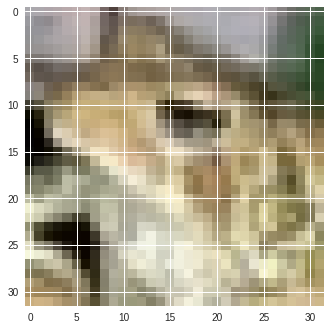

In [30]:
imshow(small_testset[0][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[0].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[0].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[0].item()])

Default Model Predicted Label:  bird
Model1 Predicted Label:  bird
Model2 Predicted Label:  bird


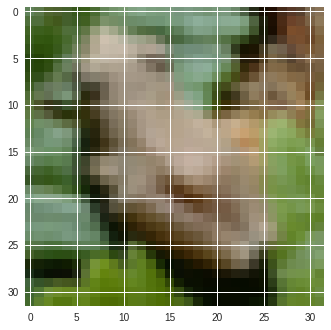

In [31]:
imshow(small_testset[1][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[1].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[1].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[1].item()])

Default Model Predicted Label:  deer
Model1 Predicted Label:  deer
Model2 Predicted Label:  deer


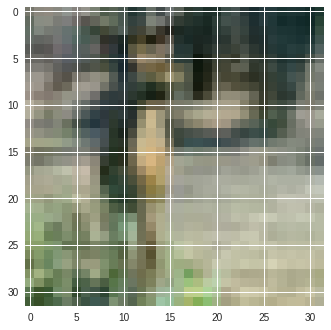

In [32]:
imshow(small_testset[2][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[2].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[2].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[2].item()])

Default Model Predicted Label:  ship
Model1 Predicted Label:  ship
Model2 Predicted Label:  car


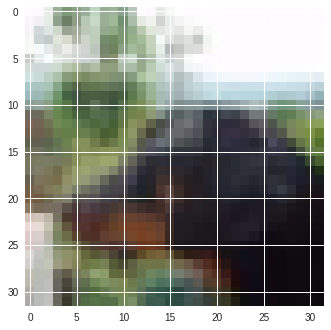

In [33]:
imshow(small_testset[3][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[3].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[3].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[3].item()])

Default Model Predicted Label:  truck
Model1 Predicted Label:  dog
Model2 Predicted Label:  dog


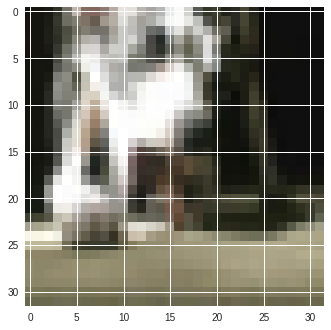

In [34]:
imshow(small_testset[4][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[4].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[4].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[4].item()])